In [1]:
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import datasets
import sklearn.gaussian_process as gp
import time

## Gaussian Processes Experiments

In the notebook below runs Gaussian Process experiments on each type of data generated. The basic structure is:

OOD Data Type:
 - data generation
 - GP experiments (with different kernels/parameters)
 
Compared to the report notebook, this includes more experiments ran on adjusted parameters. The unsuccessful or repetitive experiments are not included in the final report notebook

In [6]:
def uncertainty(pred_proba):
    most_probable = np.max(pred_proba, axis = 1)
    return 1-most_probable
    
#define the gaussian process model
def gaussian(df, kernel, title, l = 16, no_ood = True):
    start = time.time()
    #first get train x and train y (without including OOD data)
    if no_ood:
        train_df = df[df.label!='OOD']
        train_y = np.array(list(train_df.label))
    else:
        train_df = df
        train_y = df.label.replace('OOD', -1).values
    train_x = train_df.drop(columns = ['label']).values
    #initialize model
    model = gp.GaussianProcessClassifier(kernel=kernel)
    model.fit(train_x, train_y)
    params = model.kernel_.get_params()
    #predict with OOD data
    whole_y = df.label.replace('OOD', -1).values
    whole_x = df.drop(columns = ['label']).values
    y_pred = model.predict(whole_x)
    
    fig, ax = plt.subplots(1, 2, figsize = (15, 5))
    #plot the predictions
    df_new = pd.DataFrame(dict(x=whole_x[:,0], y=whole_x[:,1], label=y_pred))
    sns.scatterplot(data=df_new, x="x", y="y", hue="label", ax = ax[0]);
    
    #Plot the uncertainties
    x = np.linspace(-l,l,1000).reshape(-1,1)
    y = np.linspace(-l,l,1000).reshape(-1,1)
    X,Y = np.meshgrid(x,y)
    Z = np.zeros((1000,1000))

    for i in range(1000):
        xy = np.concatenate((X[i].reshape(-1,1), Y[i].reshape(-1,1)), axis = 1)
        y_pred_new = model.predict_proba(xy)
        Z[i] = uncertainty(y_pred_new)

    ax[1].pcolormesh(X, Y, Z, shading='gouraud', vmin=Z.min(), vmax=Z.max())
    ax[1].scatter(df[df.label==0].x, df[df.label==0].y, color = 'blue')
    ax[1].scatter(df[df.label==1].x, df[df.label==1].y, color = 'green')
    ax[1].scatter(df[df.label==2].x, df[df.label==2].y, color = 'red')
    ax[1].scatter(df[df.label=='OOD'].x, df[df.label=='OOD'].y, color = 'yellow')
    ax[0].set_title('{} predictions'.format(title))
    ax[1].set_title('{} uncertainties'.format(title))
    print('execution time: {} mins'.format((time.time()-start)/60))
    return model, ax

### 1. Well-Seperated and Linearly-Seperable

In [3]:
# generate 3 classes
X, y = datasets.make_blobs(n_samples=[200,200,200], 
                           centers=[[0, 3], [-3, -3], [3, -3]], 
                           cluster_std=0.9, 
                           n_features=2, 
                           random_state=0)

#### a) ODD-ring

In [4]:
# generate OOD
np.random.seed(0)
r = 6.8 # radius
x1, x2 = [], []
for _ in range(500):
    # random angle
    angle = np.random.uniform(0,2 * np.pi)
    x1.append((r + random.random())*np.cos(angle))
    x2.append(-.5+(r + random.random())*np.sin(angle))

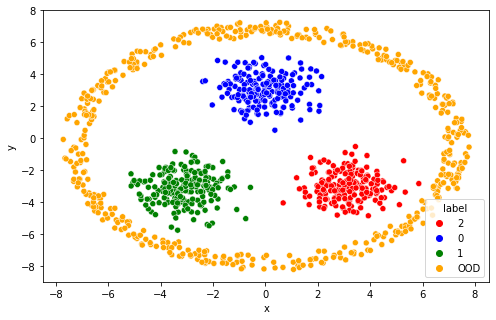

In [5]:
df1a = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
df1a_ood = pd.DataFrame(dict(x=x1, y=x2, label='OOD'))
df1a = df1a.append(df1a_ood, ignore_index=True)

plt.figure(figsize=[8,5])
sns.scatterplot(data=df1a, x="x", y="y", hue="label", palette=["red", "blue", "green", "orange"]);

execution time: 1.2854519327481588 mins
execution time: 0.7591883818308512 mins
execution time: 1.180796198050181 mins


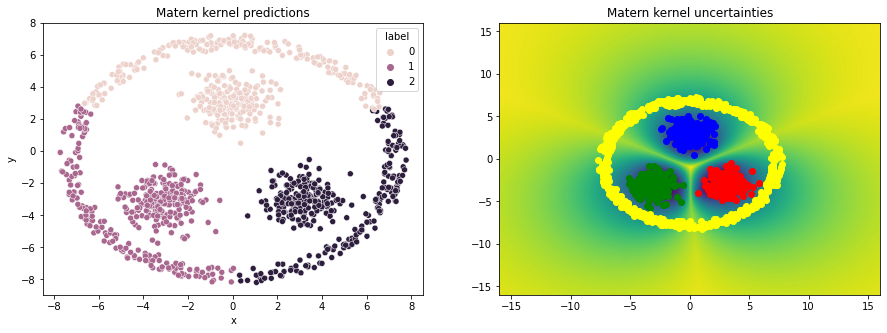

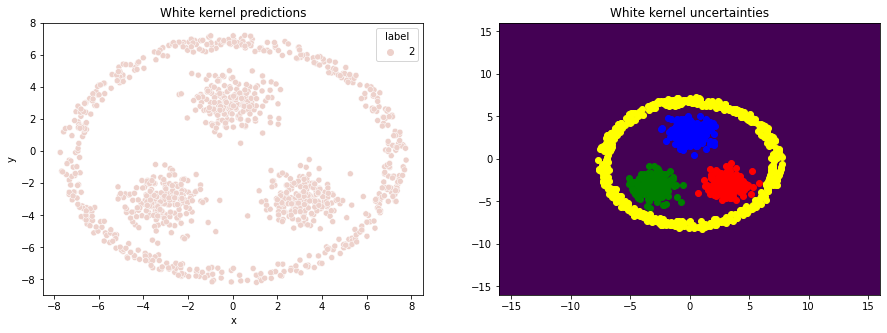

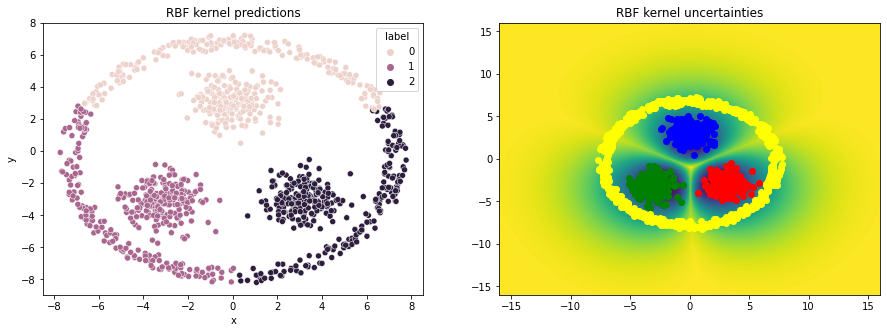

In [8]:
#adjust kernel parameters
kernel1 = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.Matern(length_scale=1.0, nu=1.5)
model1a1, ax1 = gaussian(df1a, kernel1, 'Matern kernel')
kernel2 = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.WhiteKernel(noise_level=0.5)
model1a2, ax2 = gaussian(df1a, kernel2, 'White kernel')
kernel3 = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RBF(1.0, (1e-3, 1e3))
model1a2, ax3 = gaussian(df1a, kernel3, 'RBF kernel')
plt.show()

execution time: 1.2061641375223795 mins
execution time: 1.3130409002304078 mins
execution time: 1.3420941710472107 mins


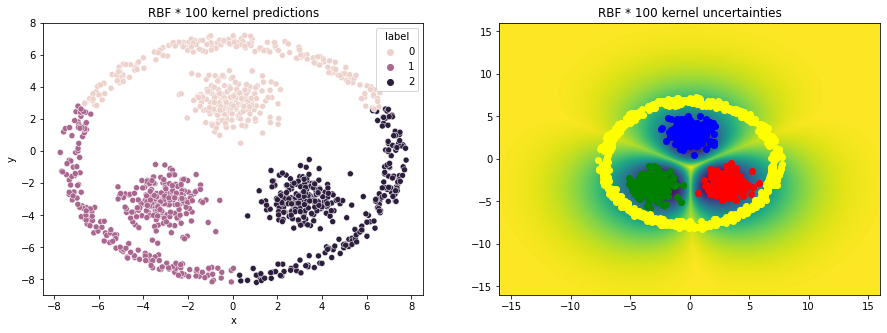

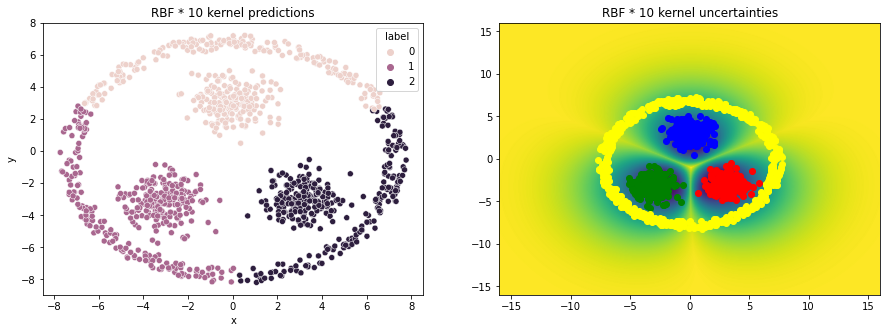

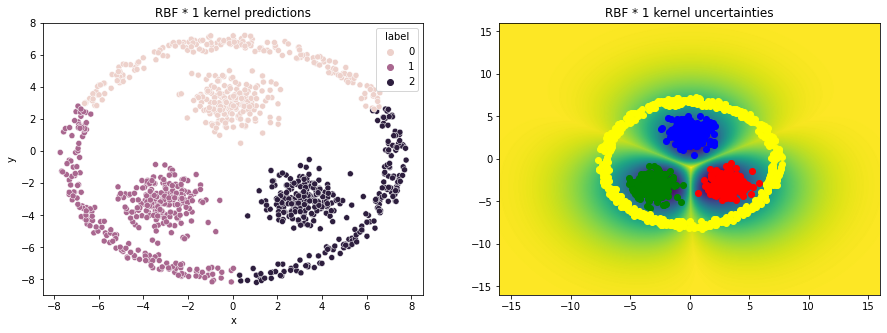

In [9]:
#adjust kernel parameters
kernel1 = gp.kernels.ConstantKernel(100.0, (1e-1, 1e3)) * gp.kernels.RBF(1.0, (1e-3, 1e3))
model1a1, ax1 = gaussian(df1a, kernel1, 'RBF * 100 kernel')
kernel2 = gp.kernels.ConstantKernel(10.0, (1e-1, 1e3)) * gp.kernels.RBF(1.0, (1e-3, 1e3))
model1a2, ax2 = gaussian(df1a, kernel2, 'RBF * 10 kernel')
kernel3 = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RBF(1.0, (1e-3, 1e3))
model1a2, ax3 = gaussian(df1a, kernel3, 'RBF * 1 kernel')
plt.show()

#### b) OOD-semicircle

In [10]:
# generate OOD
np.random.seed(0)
r = 6 # radius
x1, x2 = [], []
for _ in range(500):
    # random angle
    angle = np.random.uniform(0,np.pi)
    x1.append((r + random.random())*np.cos(angle))
    x2.append((r + random.random())*np.sin(angle))

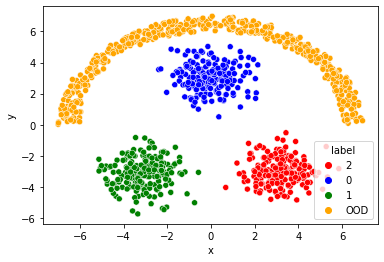

In [11]:
df1b = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
df1b_ood = pd.DataFrame(dict(x=x1, y=x2, label='OOD'))
df1b = df1b.append(df1b_ood, ignore_index=True)

sns.scatterplot(data=df1b, x="x", y="y", hue="label", palette=["red", "blue", "green", "orange"]);

execution time: 1.3531912803649901 mins
execution time: 2.7053171157836915 mins
execution time: 1.7974902629852294 mins


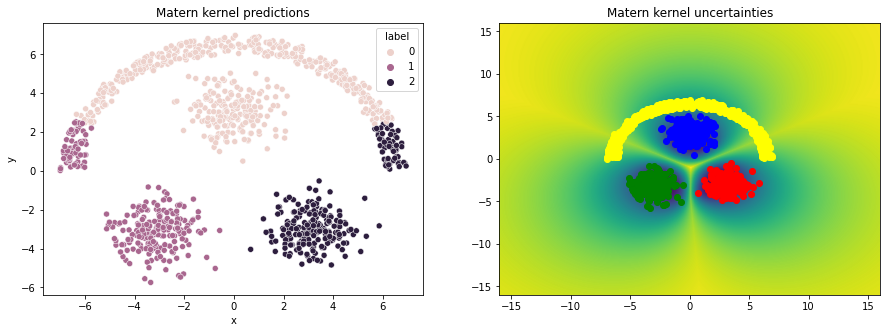

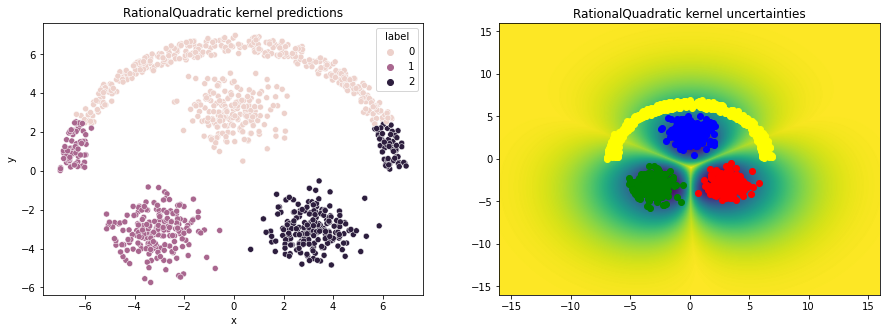

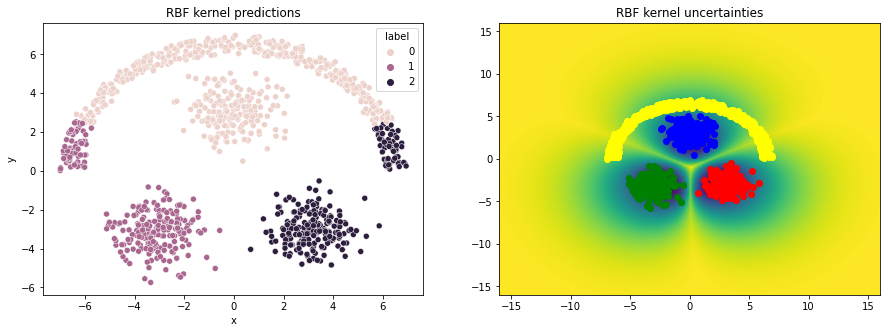

In [12]:
#adjust kernel parameters
kernel1 = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.Matern(length_scale=1.0, nu=1.5)
model1b1, ax1 = gaussian(df1b, kernel1, 'Matern kernel')
kernel2 = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RationalQuadratic(length_scale=1.0, alpha=1.5)
model1b2, ax2 = gaussian(df1b, kernel2, 'RationalQuadratic kernel')
kernel3 = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RBF(1.0, (1e-3, 1e3))
model1b2, ax3 = gaussian(df1b, kernel3, 'RBF kernel')
plt.show()

### 2. Well-Seperated and Linearly-Seperable, but clusters are far away from each other

In [13]:
# generate 3 classes
X, y = datasets.make_blobs(n_samples=[200,200,200], 
                           centers=[[0, 6], [-6, -6], [6, -6]], 
                           cluster_std=1, 
                           n_features=2, 
                           random_state=0)

#### a) one ODD boundary

In [14]:
# generate OOD
np.random.seed(0)
r = 11.5 # radius
x1, x2 = [], []
for _ in range(500):
    # random angle
    angle = np.random.uniform(0,2 * np.pi)
    x1.append((r + random.random())*np.cos(angle))
    x2.append(-1+(r + random.random())*np.sin(angle))

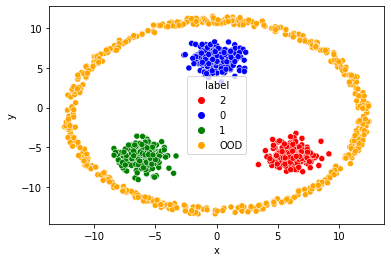

In [15]:
df2a = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
df2a_ood = pd.DataFrame(dict(x=x1, y=x2, label='OOD'))
df2a = df2a.append(df2a_ood, ignore_index=True)

sns.scatterplot(data=df2a, x="x", y="y", hue="label", palette=["red", "blue", "green", "orange"]);

execution time: 1.9599053184191386 mins
execution time: 1.9701719800631206 mins
execution time: 2.0755907853444415 mins


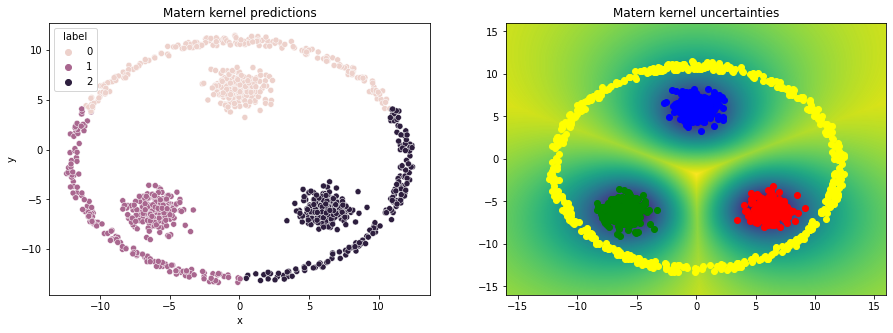

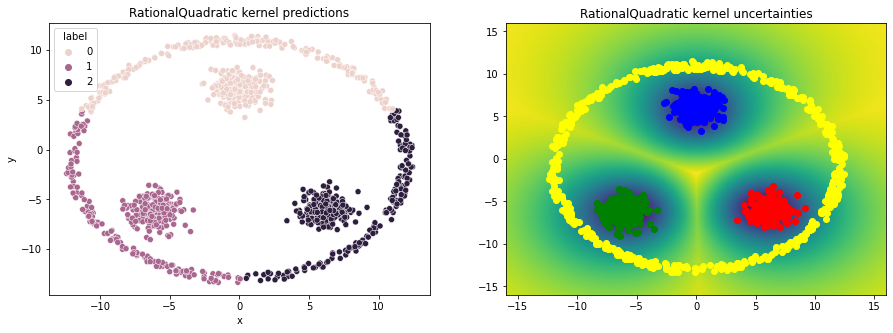

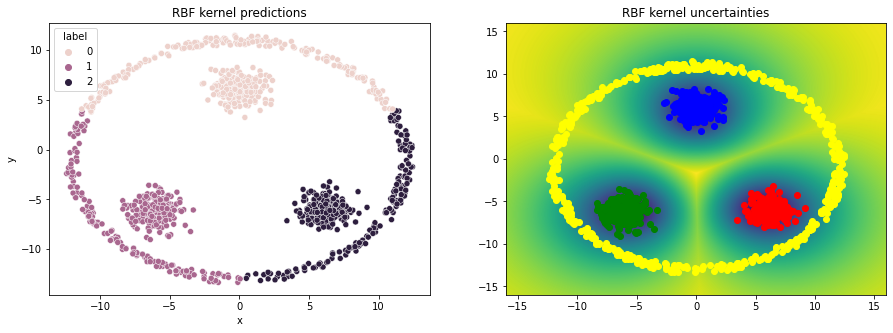

In [16]:
#adjust kernel parameters
kernel1 = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.Matern(length_scale=1.0, nu=1.5)
model2a1, ax1 = gaussian(df2a, kernel1, 'Matern kernel')
kernel2 = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RationalQuadratic(length_scale=1.0, alpha=1.5)
model2a2, ax2 = gaussian(df2a, kernel2, 'RationalQuadratic kernel')
kernel3 = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RBF(1.0, (1e-3, 1e3))
model2a3, ax3 = gaussian(df2a, kernel3, 'RBF kernel')
plt.show()

#### b) three ODD boundary

In [17]:
# generate OOD
np.random.seed(42)
r = 3.5 # radius
cx1, cx2, cx3 = 0, -6, 6
cy1, cy2, cy3 = 6, -6, -6
x1, x2 = [], []
for _ in range(500//3):
    # random angle
    angle = np.random.uniform(0,2 * np.pi)
    x1.append(cx1 + (r + random.random())*np.cos(angle))
    x1.append(cx2 + (r + random.random())*np.cos(angle))
    x1.append(cx3 + (r + random.random())*np.cos(angle))
    x2.append(cy1 + (r + random.random())*np.sin(angle))
    x2.append(cy2 + (r + random.random())*np.sin(angle))
    x2.append(cy3 + (r + random.random())*np.sin(angle))

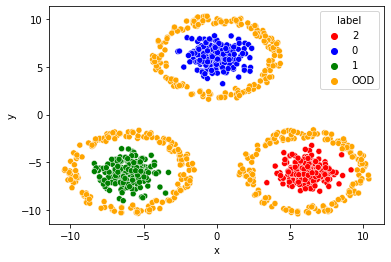

In [18]:
df2b = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
df2b_ood = pd.DataFrame(dict(x=x1, y=x2, label='OOD'))
df2b = df2b.append(df2b_ood, ignore_index=True)

sns.scatterplot(data=df2b, x="x", y="y", hue="label", palette=["red", "blue", "green", "orange"]);

execution time: 2.544322097301483 mins
execution time: 3.02801429828008 mins
execution time: 2.0831257184346517 mins


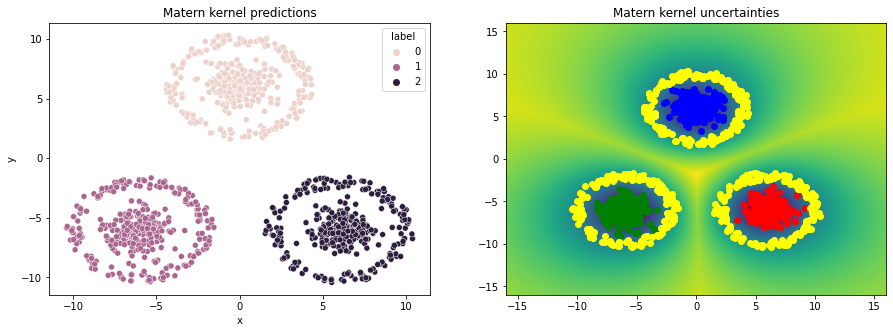

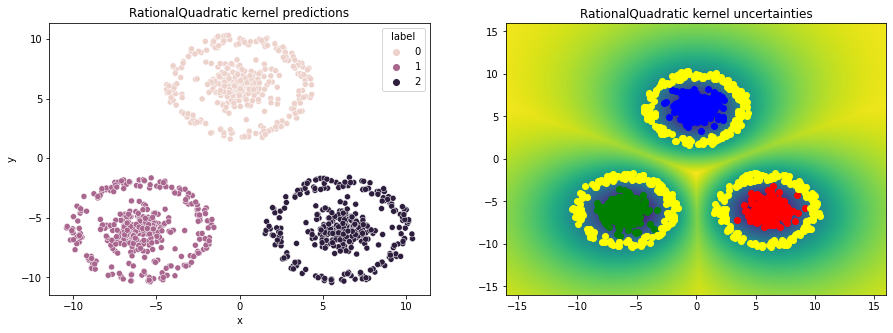

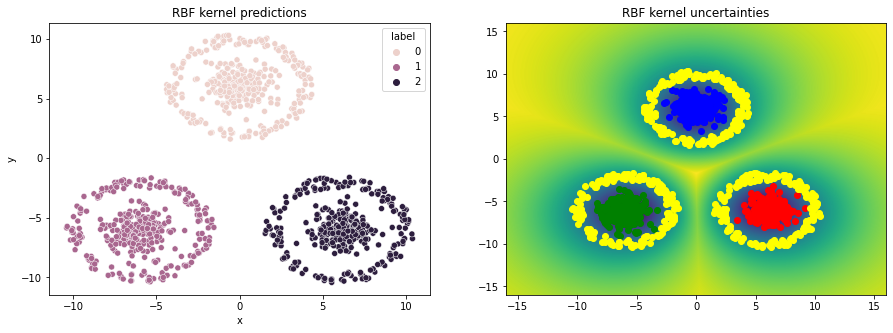

In [19]:
# model2b = gaussian(df2b)

# model1b, ax = gaussian(df1b)

#adjust kernel parameters
kernel1 = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.Matern(length_scale=1.0, nu=1.5)
model2b1, ax1 = gaussian(df2b, kernel1, 'Matern kernel')
kernel2 = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RationalQuadratic(length_scale=1.0, alpha=1.5)
model2b2, ax2 = gaussian(df2b, kernel2, 'RationalQuadratic kernel')
kernel3 = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RBF(1.0, (1e-3, 1e3))
model2b2, ax3 = gaussian(df2b, kernel3, 'RBF kernel')
plt.show()

### 3. Not Well-Seperated

In [20]:
# generate 3 classes
X, y = datasets.make_blobs(n_samples=[200,200,200], 
                           centers=[[0, 1], [-1, -1], [1, -1]], 
                           cluster_std=1, 
                           n_features=2, 
                           random_state=0)

In [21]:
# generate OOD
np.random.seed(42)
r = 4.5 # radius
x1, x2 = [], []
for _ in range(500):
    # random angle
    angle = np.random.uniform(0,2 * np.pi)
    x1.append((r + random.random())*np.cos(angle))
    x2.append((r + random.random())*np.sin(angle))

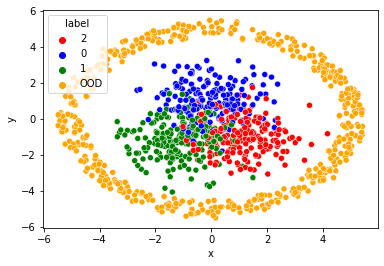

In [22]:
df3 = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
df3_ood = pd.DataFrame(dict(x=x1, y=x2, label='OOD'))
df3 = df3.append(df3_ood, ignore_index=True)

sns.scatterplot(data=df3, x="x", y="y", hue="label", palette=["red", "blue", "green", "orange"]);

execution time: 2.09048855304718 mins
execution time: 2.548686170578003 mins
execution time: 1.3244968811670939 mins


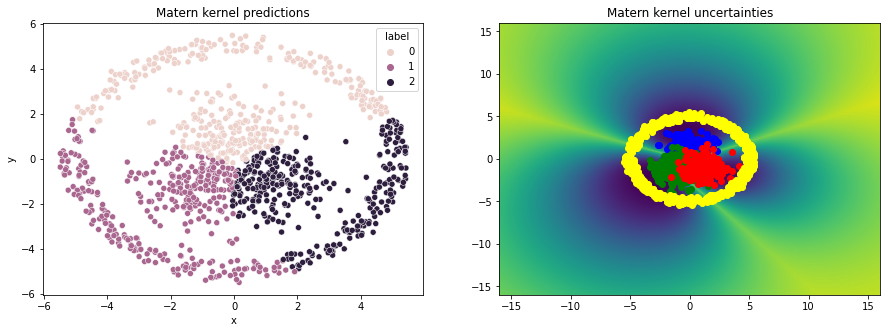

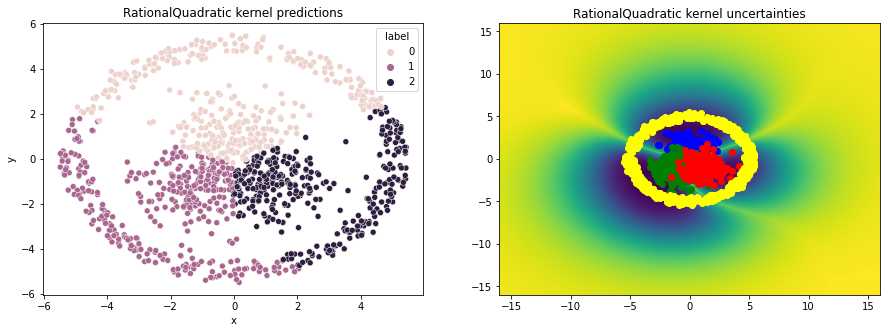

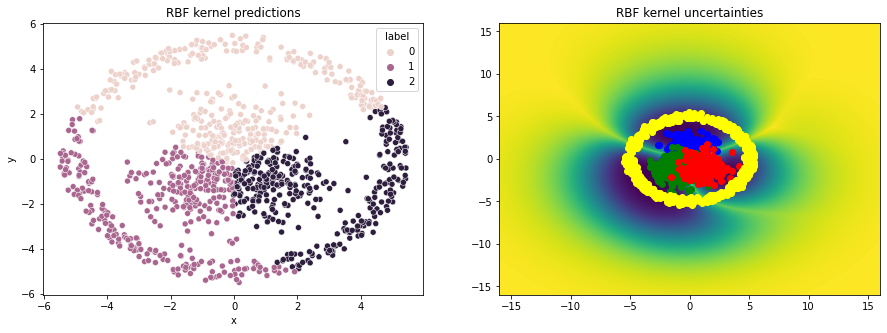

In [23]:
# model3 = gaussian(df3, l = 5)

# model1b, ax = gaussian(df1b)

#adjust kernel parameters
kernel1 = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.Matern(length_scale=1.0, nu=1.5)
model31, ax1 = gaussian(df3, kernel1, 'Matern kernel')
kernel2 = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RationalQuadratic(length_scale=1.0, alpha=1.5)
model32, ax2 = gaussian(df3, kernel2, 'RationalQuadratic kernel')
kernel3 = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RBF(1.0, (1e-3, 1e3))
model32, ax3 = gaussian(df3, kernel3, 'RBF kernel')
plt.show()

### 4. Well-Seperated by non-linear boundary

In [24]:
X, y = datasets.make_moons(n_samples=600, shuffle=True, noise=0.1, random_state=0)

In [25]:
# generate OOD
np.random.seed(0)
r = 2 # radius
x1, x2 = [], []
for _ in range(500):
    # random angle
    angle = np.random.uniform(0,2 * np.pi)
    x1.append(.5+(r + random.random())*np.cos(angle))
    x2.append(.3+(r + random.random())/1.5*np.sin(angle))

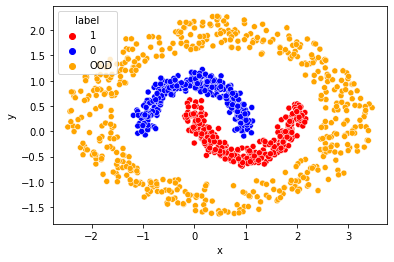

In [26]:
df1a = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
df1a_ood = pd.DataFrame(dict(x=x1, y=x2, label='OOD'))
df1a = df1a.append(df1a_ood, ignore_index=True)

sns.scatterplot(data=df1a, x="x", y="y", hue="label", palette=["red", "blue", "orange"]);

execution time: 0.5857388178507487 mins
execution time: 1.0576802651087442 mins
execution time: 0.6913295348485311 mins


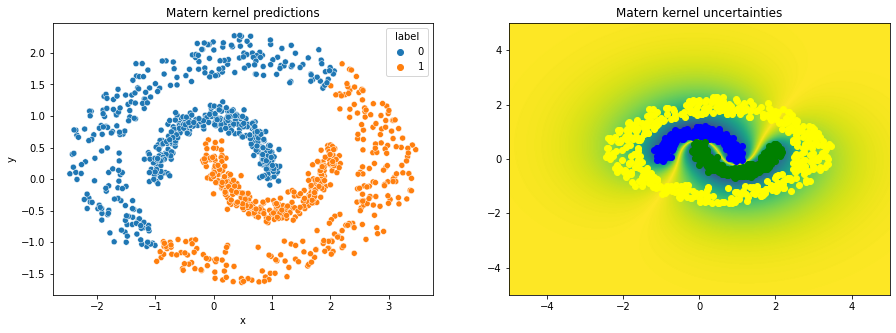

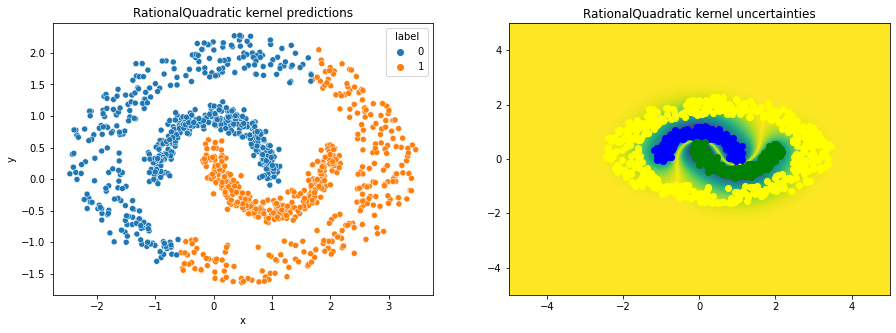

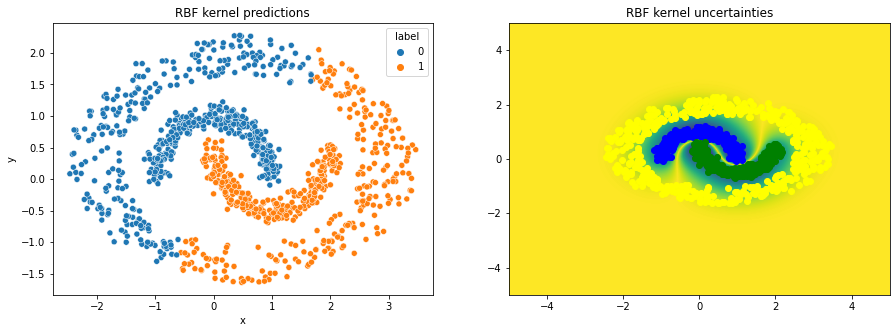

In [27]:
# model4 = gaussian(df1a, l = 5)

# model1b, ax = gaussian(df1b)

#adjust kernel parameters
kernel1 = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.Matern(length_scale=1.0, nu=1.5)
model41, ax1 = gaussian(df1a, kernel1, 'Matern kernel', l = 5)
kernel2 = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RationalQuadratic(length_scale=1.0, alpha=1.5)
model42, ax2 = gaussian(df1a, kernel2, 'RationalQuadratic kernel', l = 5)
kernel3 = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RBF(1.0, (1e-3, 1e3))
model42, ax3 = gaussian(df1a, kernel3, 'RBF kernel', l = 5)
plt.show()

MNIST Data

In [38]:
from sklearn.model_selection import train_test_split
import sklearn

In [30]:
# Load data from https://www.openml.org/d/554
X, y = datasets.fetch_openml('mnist_784', version=1, return_X_y=True)

In [29]:
# Pick out 3 classes of digits: 0, 1, 2 and take a subset of samples as in-distribution points
X_0, y_0 = X[(y == '0')][:500], y[(y == '0')][:500].astype(int)
X_1, y_1 = X[(y == '1')][:500], y[(y == '1')][:500].astype(int)
X_2, y_2 = X[(y == '2')][:500], y[(y == '2')][:500].astype(int)
# sample from digit 3 as OODs
X_ood, y_ood = X[(y == '3')][:500], ['OOD'] * 500

In [31]:
# combine data
X_mnist = np.concatenate((X_0, X_1, X_2, X_ood))
y_mnist = np.concatenate((y_0, y_1, y_2, y_ood))

In [34]:
l = 16
start = time.time()
#first get train x and train y (without including OOD data)
X_new = np.concatenate((X_0, X_1, X_2))
y_new = np.concatenate((y_0, y_1, y_2))
#split out a 10% validation set
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.1)
#initialize model
kernel = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RBF(1.0, (1e-3, 1e3))
model = gp.GaussianProcessClassifier(kernel=kernel)
model.fit(X_train, y_train)
print('execution time: {} mins'.format((time.time()-start)/60))

execution time: 0.25918715000152587 mins


In [40]:
X_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [41]:
y_train

array([1, 2, 2, ..., 0, 0, 2])

In [35]:
y_pred_test = model.predict(X_test)
y_pred_proba_test = model.predict_proba(X_test)

In [39]:
#evaluate accuracy

acc = sklearn.metrics.accuracy_score(y_test, y_pred_test)
acc

0.34

In [42]:
df1a.label.replace('OOD', -1).values

array([ 1,  0,  0, ..., -1, -1, -1])

In [43]:
df1a.drop(columns = ['label']).values

array([[ 0.79376821, -0.51480339],
       [ 0.24846934,  0.97421613],
       [-0.6473948 ,  0.74392718],
       ...,
       [-1.1354143 ,  1.20688593],
       [ 0.52831828,  1.75671213],
       [-2.26315811,  0.22994236]])